In [1]:
import pm4py
import pandas as pd
import numpy as np

# pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 200

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
log = pd.read_csv("abstract_log-starts_ends-1.csv")
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])

## Method 2: frequent - simult

### Candidate / Integrated Search

In [ ]:
log2 = log[(log['concept:name'].str.contains("Candidate")) | log['concept:name'].str.contains("Integrated")]
log2

In [ ]:
traces = log2.groupby('case:concept:name')['concept:name'].apply(tuple).to_list()
traces

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(traces).transform(traces)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

In [ ]:
from mlxtend.frequent_patterns import apriori, fpgrowth

# itemsets = apriori(df, min_support=0.5, use_colnames=True)
itemsets = fpgrowth(df, min_support=0.6, use_colnames=True)
itemsets['length'] = itemsets['itemsets'].apply(lambda x: len(x))
itemsets = itemsets[itemsets['length'] >= 2]
# itemsets.to_csv("itemsets-method2.csv")
itemsets

In [ ]:
itemset = itemsets['itemsets'].iloc[-1]
itemset

In [ ]:
from mine_utils import aggregate_events

# itemset = ('Integrated Search:end', 'Candidate Search:end')
# 13,0.9998259658893143,"frozenset({'Candidate Search:end', 'Integrated Search:end'})",2
# groups: 5746 total size: 11491 avg size: 1.9998259658893143
# groups: 5746 # simult: 5746 avg: 100.0 %
# groups: 5746 avg_diff: 1980 s ( 33 m )
# {('Integrated Search:end', 'Candidate Search:end'): 0, ('Candidate Search:end', 'Integrated Search:end'): 0}

# itemset = ('Candidate ID Decision:end','Candidate ID Decision:start','Candidate ID:end','Candidate ID:start','Candidate Search:end','Candidate Search:start','Integrated Search:end','Integrated Search:start')
# groups: 5746 total size: 45544 avg size: 7.93
# groups: 5746 # simult: 4349 avg: 75.69 %
# groups: 5746 avg_diff: 23314 s ( 388 m )

# for itemset in itemsets['itemsets']:
#     print(itemset)
max_timedelta = 10 * 60 # * pow(10,9) # nano to seconds
log3 = aggregate_events(log2, itemset, max_timedelta)

# print()

# 'Integrated Search:end' -> 'Candidate Search:end'

In [ ]:
log3 = log3.sort_values(by=['case:concept:name', 'time:timestamp'])

In [ ]:
# double checking for when replacing timestamps

# diff = log3[log3['concept:name'].isin(itemset)].groupby('case:concept:name')['time:timestamp'].diff().astype(int)
# diff = diff / pow(10, 9)
# diff[(diff > 0) & (diff != 1)]

In [ ]:
from mine_utils import mine_alpha
mine_alpha(log3)

In [ ]:
from variant_stats import get_variants_stats, get_covering_variants, filter_traces_on_variants

var_stats = get_variants_stats(log3)
var_stats

### Biometric / Biographic (minus fees)

In [ ]:
log2 = log[((log['concept:name'].str.contains("Biometric")) | log['concept:name'].str.contains("Biographic")) & (~ log['concept:name'].str.contains("Fee"))]
log2

In [ ]:
itemset = log2['concept:name'].unique()
itemset

In [ ]:
max_timedelta = 10 * 60 # * pow(10,9) # nano to seconds
log3 = aggregate_events(log2, itemset, max_timedelta)

### Medical

In [ ]:
log2 = log[log['concept:name'].str.contains("Medical")]
log2

In [ ]:
itemset = log2['concept:name'].unique()

from mine_utils import aggregate_events

max_timedelta = 10 * 60 # * pow(10,9) # nano to seconds
log3 = aggregate_events(log2, itemset, max_timedelta)

### Criminality

In [ ]:
log2 = log[log['concept:name'].str.contains("Criminality")]
log2

### Fees

In [ ]:
log2 = log[log['concept:name'].str.contains("Fee")]
log2

In [ ]:
itemset = log2['concept:name'].unique()
itemset

In [ ]:
max_timedelta = 0 # 1 * 60 # * pow(10,9) # nano to seconds
_ = aggregate_events(log2, itemset, max_timedelta)

## Method 1: simult - frequent

In [ ]:
simult_evts = log.groupby(['case:concept:name', 'time:timestamp'])['concept:name'].apply(tuple)
simult_evts = simult_evts[map(lambda s: len(s)>1, simult_evts)]
simult_evts

In [ ]:
simult_evts.index = simult_evts.index.droplevel(level='time:timestamp')
simult_evts

In [ ]:
simult_evts_list = simult_evts.groupby(level=0).apply(tuple).to_list()
simult_evts_list[0]

In [ ]:
simult_evts[simult_evts.index=="1"]

In [ ]:
log[log['case:concept:name']=="1"]

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(simult_evts_list).transform(simult_evts_list)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

itemsets = apriori(df, min_support=0.1, use_colnames=True)
itemsets.sort_values(by='support', ascending=False).to_csv("tmp.csv")

In [ ]:
rules = association_rules(itemsets, metric ="lift", min_threshold = 1)
rules.sort_values(by='confidence', ascending=False)

## All

In [ ]:
log = pd.read_csv("abstract_log-starts_ends-1.csv")
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])

In [ ]:
log

Unnamed: 0  case:concept:name                      concept:name  \
0                0                  1                     Received:Date   
1                1                  1          Application Status:start   
2                2                  1     Biometric Assessment:Required   
3                3                  1                 Criminality:start   
4                4                  1      Criminality Assessment:start   
...            ...                ...                               ...   
244815      328822                998  Application Transfer:Transferred   
244816      328823                998      Eligibility Assessment:start   
244817      328824                998        Eligibility Assessment:end   
244818      328825                998          Final Assessment:Refused   
244819      328826                998            Application Status:end   

                time:timestamp  
0      2024-06-03 00:00:00.000  
1      2024-06-03 09:20:37.327  
2      2024-06-03 09:20:38.890  
3      2024-06-03 09:20:39.023  
4      2024-06-03 09:20:39.160  
...                        ...  
244815 2024-06-17 19:09:06.000  
244816 2024-06-24 15:41:48.947  
244817 2024-06-24 15:41:48.947  
244818 2024-06-24 20:54:19.710  
244819 2024-06-24 20:54:32.890  

[244820 rows x 4 columns]

In [ ]:
diff = log.groupby('case:concept:name')['time:timestamp'].diff().astype(int).rename("diff") / pow(10, 9)
diff = diff[diff >= 0]
diff

1          33637.327
2              1.563
3              0.133
4              0.137
5              0.533
             ...    
244815    214918.543
244816    592362.947
244817         0.000
244818     18750.763
244819        13.180
Name: diff, Length: 239020, dtype: float64

In [ ]:
min_timedelta = 10 * 60

to_keep = diff[diff >= min_timedelta]
to_keep

1           33637.327
16          23758.000
22           2138.917
28         916472.707
29        1359090.423
             ...     
244813      93475.130
244814     740788.327
244815     214918.543
244816     592362.947
244818      18750.763
Name: diff, Length: 39525, dtype: float64

In [ ]:
log2 = log.join(to_keep, how='inner')
log2

Unnamed: 0  case:concept:name                      concept:name  \
1                1                  1          Application Status:start   
16              16                  1                Auto Promote:start   
22              22                  1                  Biographic:start   
28              28                  1                  Verification:end   
29              29                  1             Biometrics - RCMP:end   
...            ...                ...                               ...   
244813      328820                998         Biometric - FCC - USA:end   
244814      328821                998                  Verification:end   
244815      328822                998  Application Transfer:Transferred   
244816      328823                998      Eligibility Assessment:start   
244818      328825                998          Final Assessment:Refused   

                time:timestamp         diff  
1      2024-06-03 09:20:37.327    33637.327  
16     2024-06-03 15:56:53.000    23758.000  
22     2024-06-03 16:33:10.917     2138.917  
28     2024-06-14 07:14:27.657   916472.707  
29     2024-06-30 00:45:58.080  1359090.423  
...                        ...          ...  
244813 2024-06-06 17:40:39.130    93475.130  
244814 2024-06-15 07:27:07.457   740788.327  
244815 2024-06-17 19:09:06.000   214918.543  
244816 2024-06-24 15:41:48.947   592362.947  
244818 2024-06-24 20:54:19.710    18750.763  

[39525 rows x 5 columns]

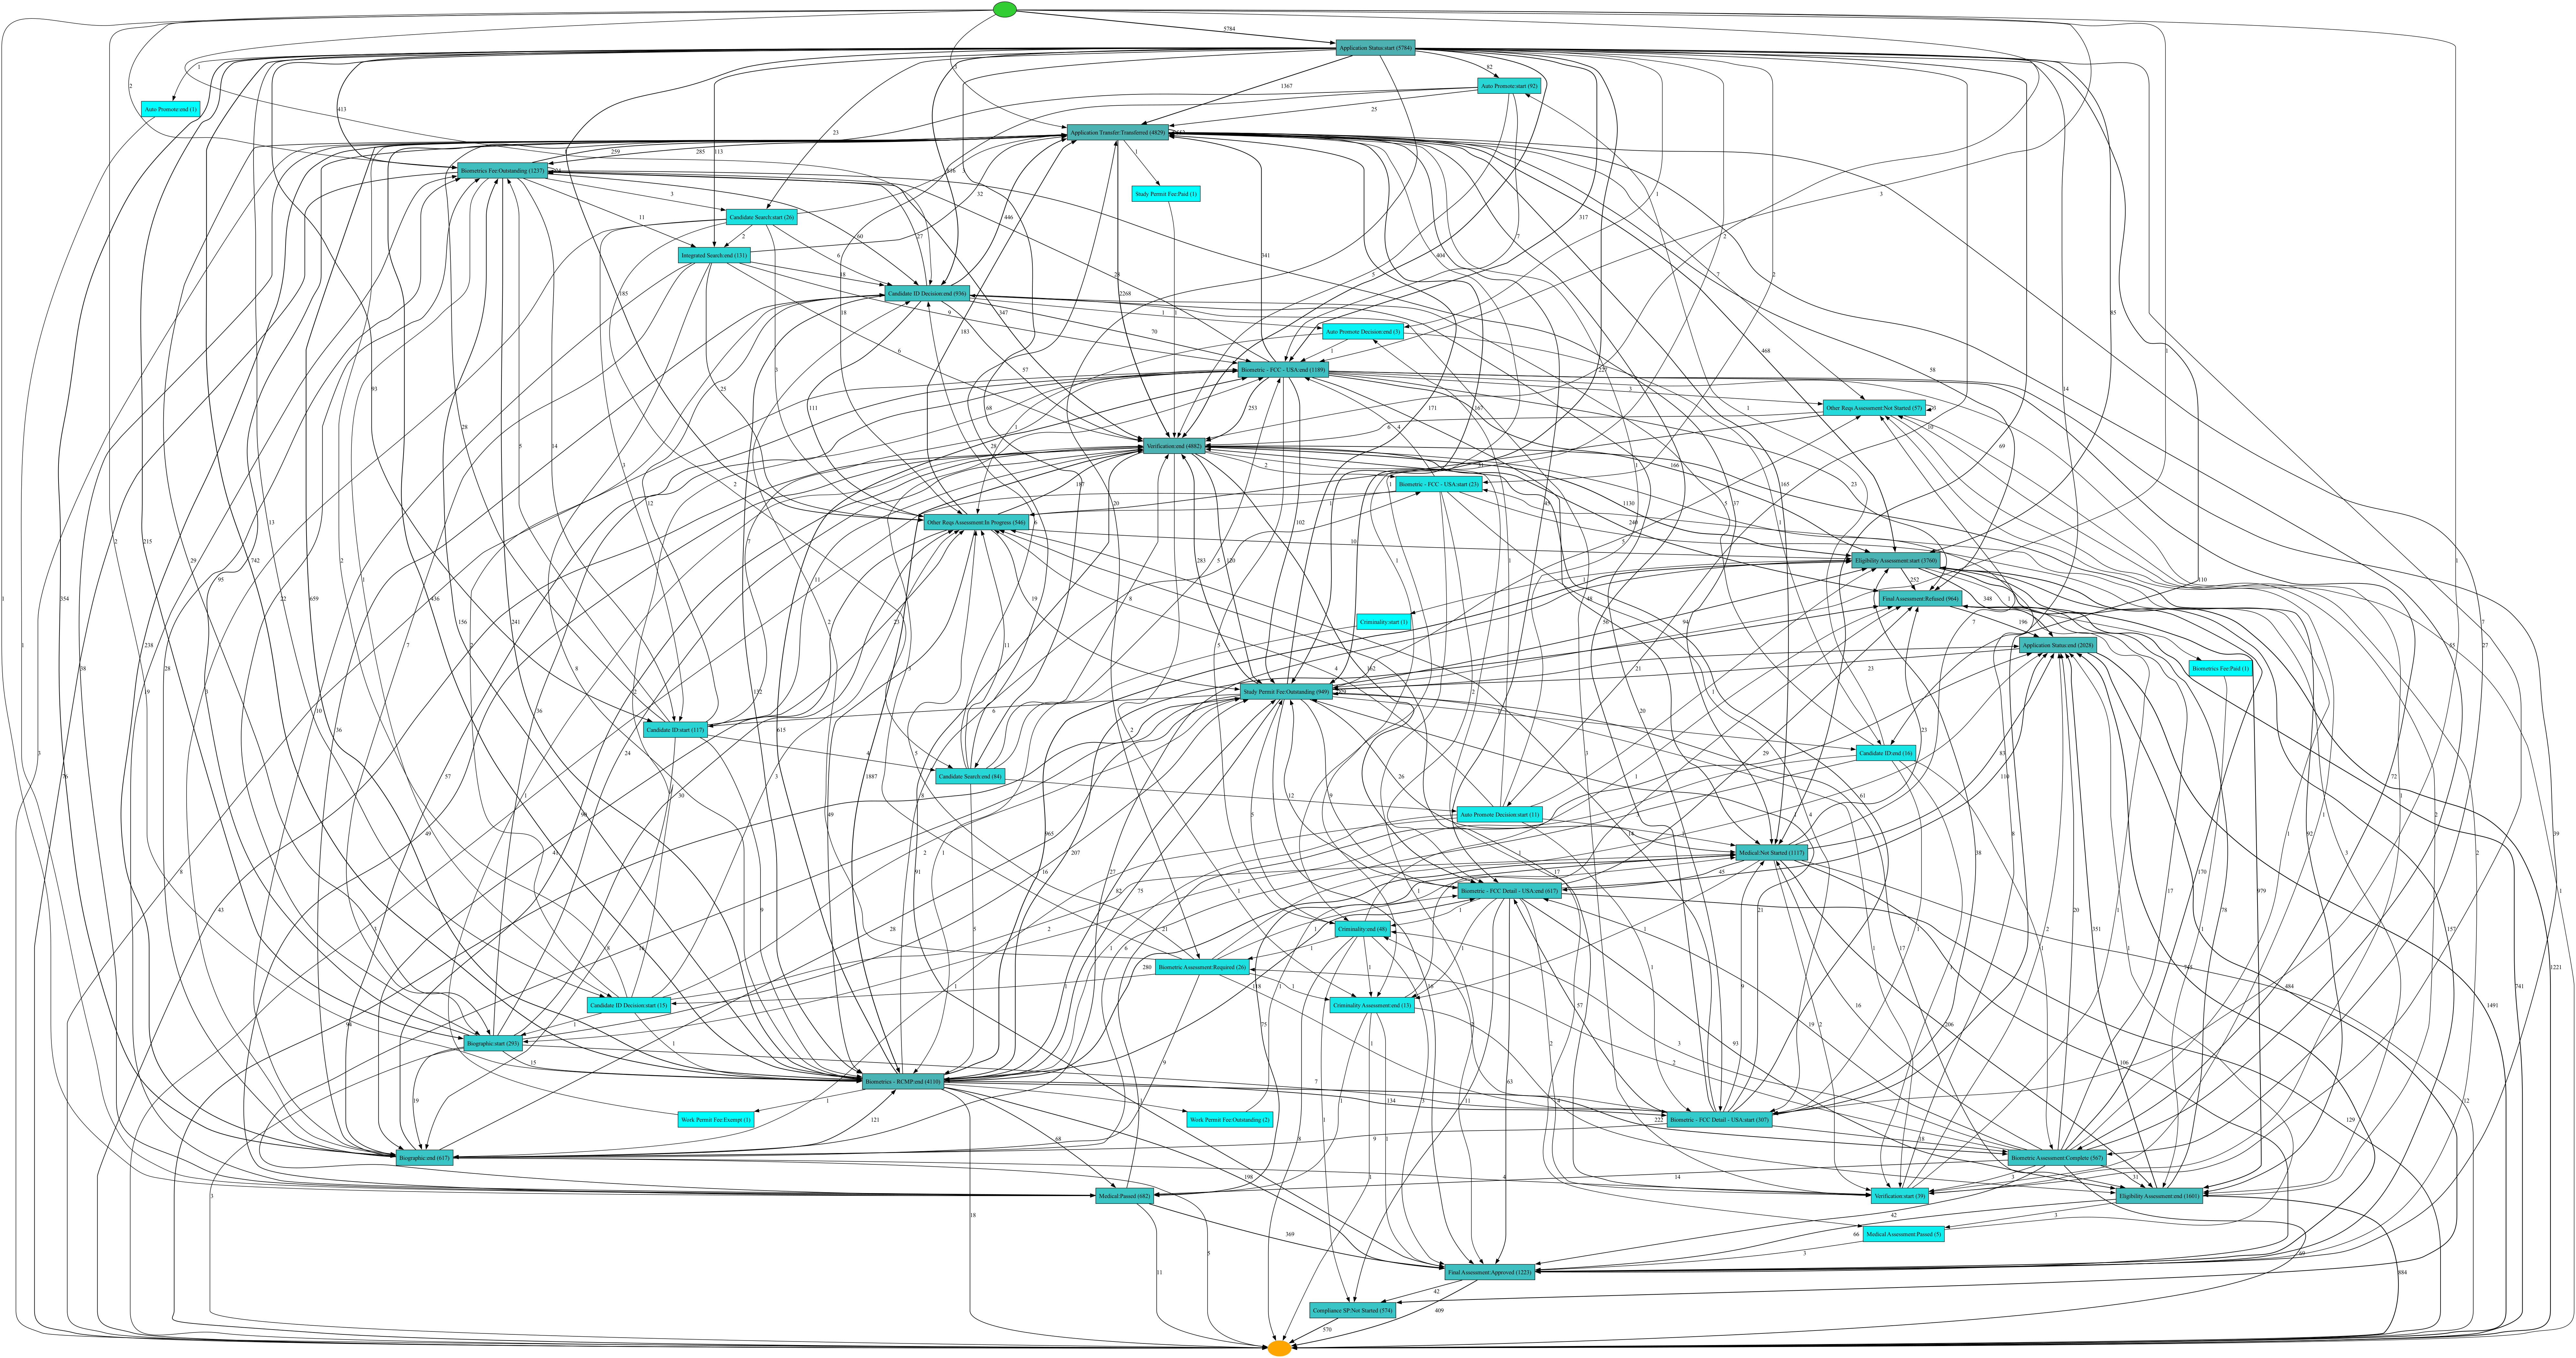

In [ ]:
from mine_utils import mine_heur
mine_heur(log2)